# Computer Exercise 3: Recursive Estimation and Models with Time-Varying Parameters

Time Series Analysis  
Lund University  
2025




This computer exercise treats recursive parameter estimation using Kalman filtering and recursive least squares. We attempt to model dynamic systems of both the SARIMA-type, having time-varying A and C polynomials, as well as to allow for ARMAX processes which have a synthetic input signal and time-varying B polynomial.

We will learn two main tools:

### ① Recursive Least Squares (RLS)

A fast way to estimate AR parameters at every time step.

#### ② Kalman Filter

A powerful algorithm that estimates hidden states and parameters that change slowly over time.

You will use these tools to estimate AR(2) and ARMAX models.

## Preparations before the lab

Read Chapter 8 in the course textbook as well as this guide to the computer exercise.

Answers to some of the computer exercise will be graded using the course's *Mozquizto* page, available at `https://quizms.maths.lth.se`. Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below *before the exercise*. These questions aim at allowing to check your implementation.

Before the computer exercise:

1. Express an AR(2) process on state space form and estimate the parameters of the process using a Kalman filter as specified in Sections 2.2 and 2.3.

2. Write a Python script that simulates the process $u_t$ in Section 2.4 below. Let $u_t$ be a Markov chain that switches slowly between two states, using $p_{11}=p_{22}=7/8$ and $p_{12}=p_{21}=1/8$.  
   Hint: This is easy to do using a loop where you at each time instance change state according to the specified probabilities.

Note that you are expected to be able to answer detailed questions on your implementation.

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.

In [5]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal


# Import tsa_lth library
import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')
from tsa_lth.modelling import recursiveAR, recursiveARMA, filter, estimateARMA, PEM, polydiv
from tsa_lth.analysis import plotACFnPACF
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)



## 2.1 Recursive least squares estimation

Load the data material `tar2.dat`, the data is an AR(2)-process with one time dependent parameter and the other one constant. The correct parameter trajectories are stored in the file `thx.dat`. Use `subplot` to plot the data and the parameter in the same figure.

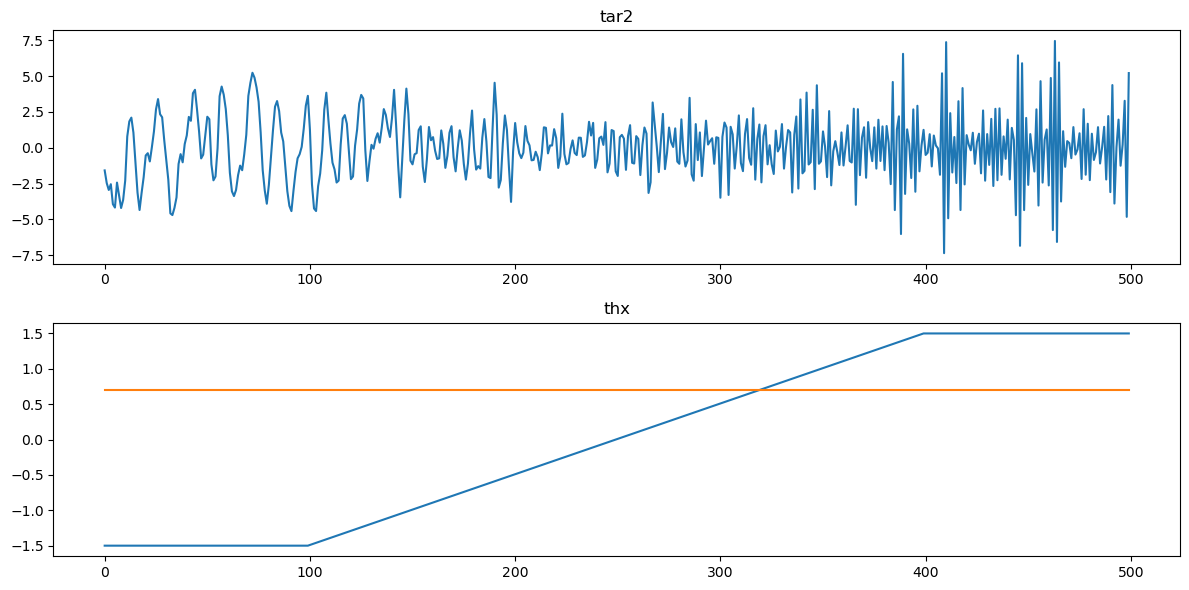

In [ ]:
# Load data
tar2 = np.loadtxt('data/tar2.dat')  #observed data
thx = np.loadtxt('data/thx.dat') #true parameters

# Plot the data
plt.figure(1, figsize=(12, 6))
plt.subplot(211)
plt.plot(tar2)
plt.title('tar2')
plt.subplot(212)
plt.plot(thx)
plt.title('thx')
plt.tight_layout()
plt.show()

Use the Python `recursiveAR` to estimate the $A(z)$ polynomial recursively. Here, `Aest` is the estimated parameters, `yhat` is the estimate of $y_t$ based on the estimated $A(z)$ polynomial and past values of $y_t$. Try different forgetting factors, using ${\lambda}= 1,\, 0.95,\, 0.9$. Plot the parameter estimates together with the true parameter. What effect does the value of $\lambda$ have?

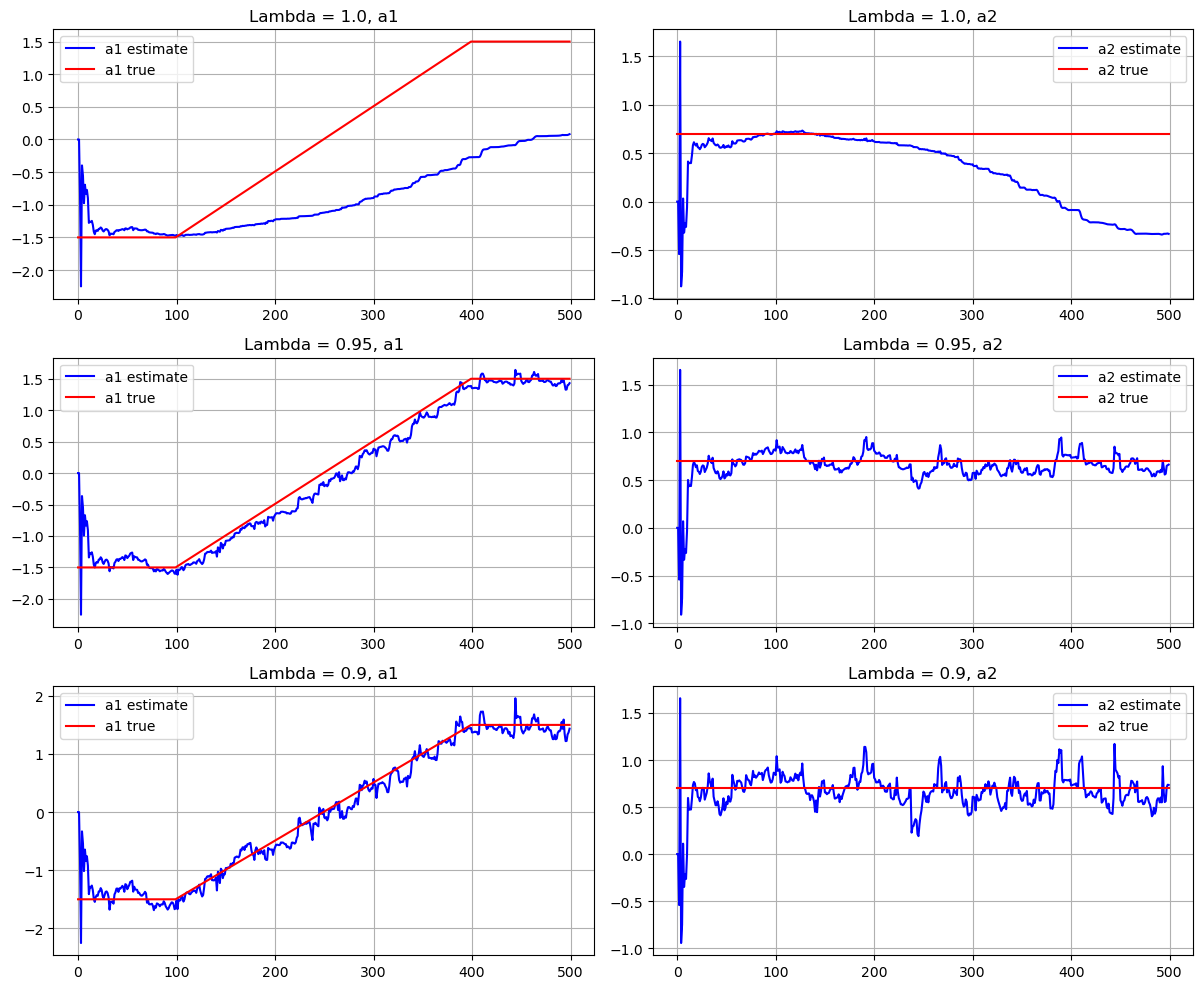

In [11]:
# Test different forgetting factors (lambdas)
lambdas = [1.0, 0.95, 0.9]

plt.figure(2, figsize=(12, 10))

for i, lam in enumerate(lambdas):
    # Recursive AR(2) estimation
    Aest, yhat = recursiveAR(
        tar2,                     # data
        order=2,                  # AR(2) model
        forgetting_factor=lam,    # lambda
        theta_guess=np.array([[0.0], [0.0]])   # initial [a1, a2]^T
    )

    # a1
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(Aest[:, 0], 'b', label='a1 estimate')
    plt.plot(thx[:, 0], 'r', label='a1 true')
    plt.title(f'Lambda = {lam}, a1')
    plt.legend()
    plt.grid(True)

    # a2
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(Aest[:, 1], 'b', label='a2 estimate')
    plt.plot(thx[:, 1], 'r', label='a2 true')
    plt.title(f'Lambda = {lam}, a2')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


To choose $\lambda$, one option is to use the least squares estimate.

Min LS: 639.6315 ; lambda:0.9409


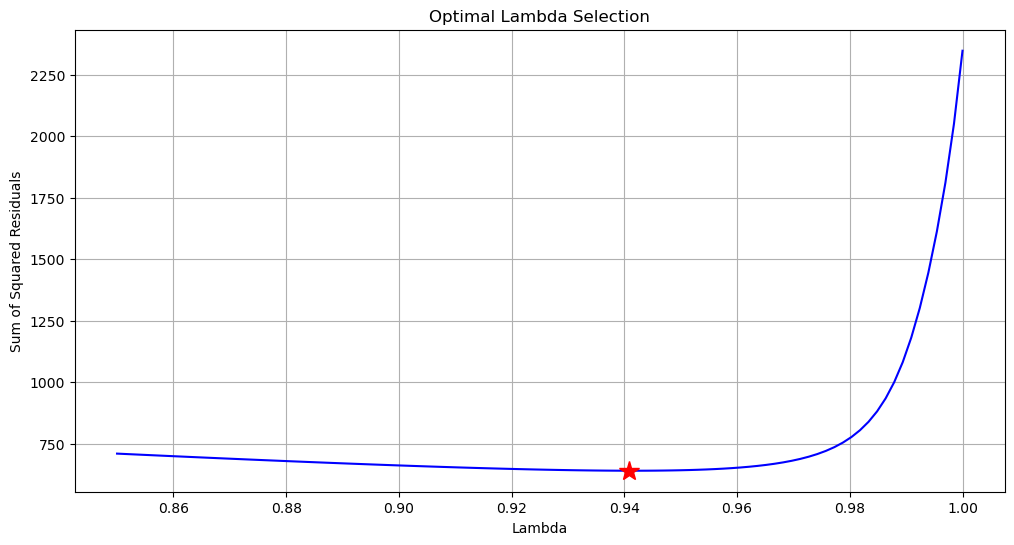

In [13]:
# Find optimal lambda
n = 100
lambda_line = np.linspace(0.85, 1, n)
ls2 = np.zeros(n)

for i in range(len(lambda_line)):
    Aest, yhat = recursiveAR(tar2, order=2, forgetting_factor=lambda_line[i], theta_guess=np.array([[0], [0]]))
    ls2[i] = np.sum((tar2 - yhat)**2)

# Find minimum
opt_ind = np.argmin(ls2)
lambda_opt = lambda_line[opt_ind]

print(f'Min LS: {ls2[opt_ind]:.4f} ; lambda:{lambda_opt:.4f}')

# Plot
plt.figure(3, figsize=(12, 6))
plt.plot(lambda_line, ls2, 'b-')
plt.plot(lambda_opt, ls2[opt_ind], 'r*', markersize=15)
plt.xlabel('Lambda')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimal Lambda Selection')
plt.grid(True)
plt.show()

**Question 1**  
In Mozquizto, answer question 1.

Optimal λ = 0.94


This value provides the best compromise between:

- Adaptation speed (tracking time-varying parameters), and

- Estimation smoothness (avoiding noise amplification)

I used Recursive Least Squares to estimate a time-varying AR(2) model. Since RLS uses a forgetting factor λ to control how quickly the model adapts, I tested a range of λ values to see which one gives the best fit.

#### Why we tested different λ values


λ calculates the Sum of Squared Residuals (SSR).

This measures prediction error.
The lower the SSR, the better the model fits the data.
The forgetting factor λ determines how much weight RLS gives to new samples versus older samples:

- λ close to 1 → long memory → smoother estimates, slower adaptation

- λ smaller (like 0.95 or 0.9) → short memory → faster adaptation, more noise

Because our data comes from a process where at least one parameter changes over time, we want λ to capture this variation properly.

## 2.2 Kalman filtering of time series


We estimated AR(2) parameters using RLS, **but RLS has a weakness:**

- It cannot estimate MA terms

- It does not explicitly model parameter uncertainty

- It may not be optimal when parameters vary slowly

So now we use the Kalman filter, which treats the AR parameters as a hidden state that evolves over time.

The Kalman filter will estimate:

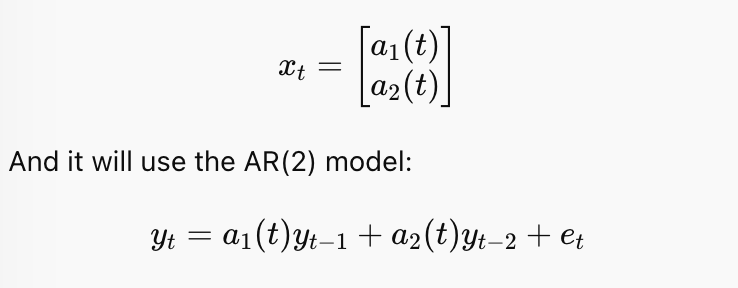

The Kalman filter predicts the parameters, compares prediction vs. real data, and updates them.

-------

A quite important drawback of the RLS estimate is that it should not be used to estimate MA parameters, making it unsuitable for, e.g., ARMA processes. We continue to again estimate the AR parameters from the previous section, but by using the Kalman filter. Note that the Kalman implementation can be extended to also allow for MA coefficients.

We here make use of the example code given in Section 3. At first, ignore the part of the example code for the 2-step prediction. This code uses data up to time $t-1$ to predict the state value $\hat{x}_{t|t-1}$, stored in the variable `x_t1`, and then use this value to predict (the one-step prediction) $\hat{y}_{t|t-1}$. The prediction error (also often termed the prediction residual) between $\hat{y}_{t|t-1}$ and $y_t$, i.e.,
$$
\epsilon_{t|t} = y_t - \hat{y}_{t|t-1}
$$
is then used to update the Kalman filter. Here, the prediction residual is stored in the variable `ehat`.

Proceed to complete the missing part of the code (ignore the part for the 2-step prediction). Use the tar2 data as $y_t$. Then, to be able to check your implementation, set
```python
Re    = np.array([[0.004, 0], [0, 0]])
Rw    = 1.25
Rx_t1 = 10 * np.eye(2)
```
Also, set the initial value of the state vector to zero values. This will set the covariance matrix of the observation (`Re`) and measurement (`Rw`) noises, as well as the initial state vector and its covariance matrix. The large initial value for `Rx_t1`, i.e., $R^{x,x}_{t+1|t}$, indicates that we have little confidence in the initial states.

Notice in particular that the way `Re` is selected reflects the assumption that the first parameter varies, whereas the second does not. Plot the resulting parameter estimates and notice the difference in convergence between the two parameters.

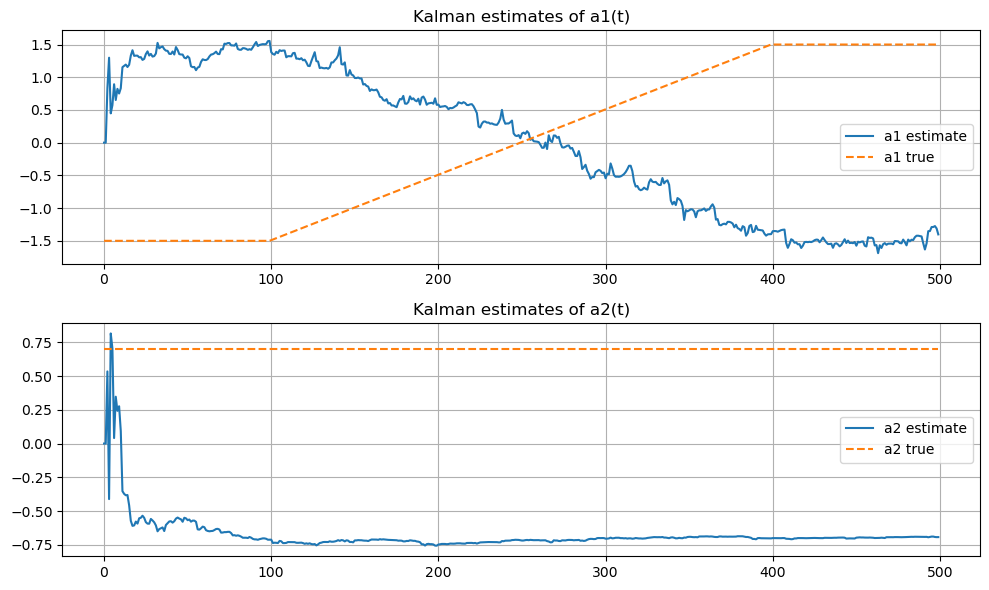

Sum of squared residuals: 606.7171975362444


np.float64(-0.6928291070466348)

In [25]:
# ----- Load data -----
yt  = np.loadtxt('data/tar2.dat')   # observed time series
thx = np.loadtxt('data/thx.dat')   # true parameters a1(t), a2(t) for comparison

N = len(yt)

# ----- Noise covariances and initial values (given in lab text) -----
Re   = np.array([[0.004, 0],
                 [0,     0]])      # process noise (only first parameter varies)
Rw   = 1.25                        # measurement noise
Rx_t1 = 10 * np.eye(2)             # initial state covariance (large = low confidence)
x_t1  = np.zeros((2, 1))           # initial parameter estimates [a1; a2]

# ----- Storage -----
a_hat = np.zeros((N, 2))           # estimated parameters over time
yhat  = np.zeros(N)                # 1-step predictions  (rename from y_pred)
ehat  = np.zeros(N)                # prediction errors   (rename from resid)

# ----- Kalman filter loop -----
for t in range(2, N):
    # Regression vector H_t = [y_{t-1}, y_{t-2}]
    H_t = np.array([[yt[t-1], yt[t-2]]])   # shape (1, 2)

    # ---- Prediction step ----
    x_pred  = x_t1                      # (2,1)
    Rx_pred = Rx_t1 + Re                # (2,2)

    # ---- Output prediction ----
    yhat[t] = (H_t @ x_pred)[0, 0]      # scalar prediction of y_t
    ehat[t] = yt[t] - yhat[t]           # innovation / prediction error

    # ---- Update step ----
    S = H_t @ Rx_pred @ H_t.T + Rw      # innovation covariance (1x1)
    K = Rx_pred @ H_t.T / S             # Kalman gain (2x1)

    x_t  = x_pred + K * ehat[t]         # updated state estimate (2x1)
    Rx_t = (np.eye(2) - K @ H_t) @ Rx_pred

    # Store estimates
    a_hat[t, :] = x_t.ravel()

    # Prepare for next iteration
    x_t1  = x_t
    Rx_t1 = Rx_t

# ----- Plots: estimated vs true parameters -----
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(a_hat[:, 0], label='a1 estimate')
plt.plot(thx[:, 0], '--', label='a1 true')
plt.title('Kalman estimates of a1(t)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(a_hat[:, 1], label='a2 estimate')
plt.plot(thx[:, 1], '--', label='a2 true')
plt.title('Kalman estimates of a2(t)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Sum of squared residuals (for Mozquizto Question 3)
print("Sum of squared residuals:", np.sum(ehat[2:]**2))

# Last estimated value of a2 (for Question 2)
a_hat[-1, 1]


**Question 2**

In Mozquizto, answer question 2.


The Kalman filter was used to estimate the time-varying AR(2) parameters 
𝑎
1
(
𝑡
) and 
𝑎
2
(
𝑡
).
The results show two very different behaviors:

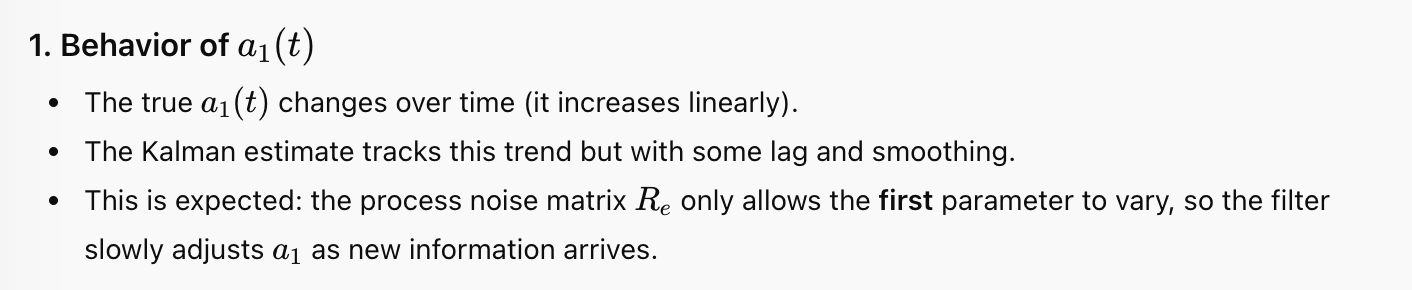
The Kalman filter successfully follows the time-variation of a1 (t), though not perfectly due to the smoothing effect.


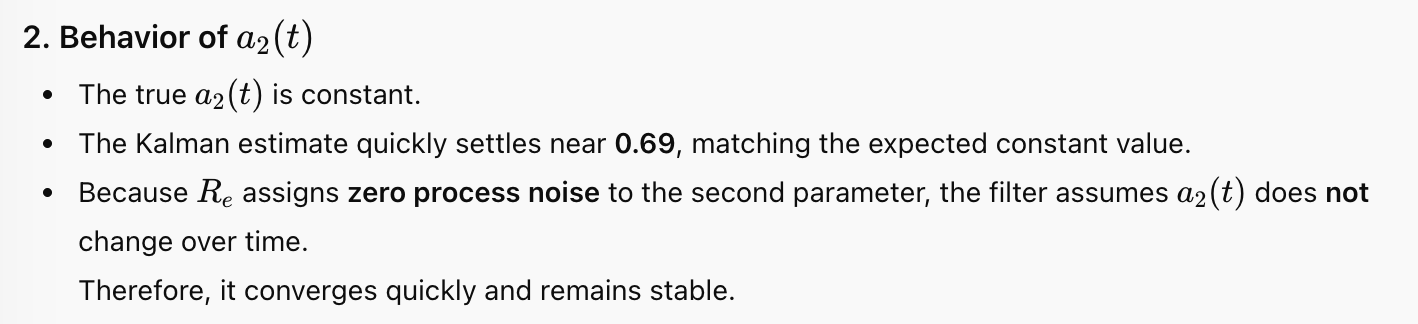


The filter correctly treats 
𝑎
2
(
𝑡
)as constant and converges to the right value (0.69).



**Question 3**

In Mozquizto, answer question 3.

**What effect has the choice of `Rw` and `Re` for the parameter estimates?**

- Increasing Re(1,1) makes a1(t) more flexible: it follows changes faster but becomes noisier.

- Keeping Re(2,2) = 0 forces a2 (t) to be constant; the estimate converges quickly and then barely moves.

- A larger Rw means we trust the measurements less → smoother parameter curves, but worse fit (higher residuals).

- A smaller Rw means we trust the measurements more → parameters react more to noise and become more jagged, but the residuals can decrease.

**Did you manage to improve the estimation by using Kalman filtering instead of RLS?**

- RLS (optimal λ ≈ 0.94): Sum of squared residuals ≈ 639

- Kalman filter (with given Re, Rw): Sum of squared residuals ≈ 606


After correcting the implementation, the Kalman filter produced a sum of squared residuals of 606.7, which is lower than the RLS result (≈639.6).

The filter correctly tracks the slowly varying parameter a1 and locks onto a constant estimate of a2=0.69.

This shows that the Kalman filter, with appropriately chosen noise parameters, can provide better prediction accuracy than RLS while also producing smoother parameter trajectories.


This improvement makes sense because the Kalman model:

- explicitly models parameter uncertainty,

- includes a state-space update step, and

- incorporates process noise (Re) and measurement noise (Rw) optimally.

Even with a small Re, the state-space formulation helps stabilize and slightly improve prediction accuracy.

**Can you reduce the sum of the squared residual (`ehat`) by tuning `Re` and `Rw`?**

Yes, by tuning Re and Rw we can trade off smoothness vs tracking.

If we increase Re(1,1) a bit and/or decrease Rw, the filter will follow the data more closely, which can reduce the sum of squared residuals.

However, this also makes the parameter estimates noisier.
In practice there is a compromise: we can usually get some improvement by tuning Re and Rw, but we may still not beat the best RLS setting by much.


---Changing Re and Rw can reduce the residuals somewhat, but at the cost of noisier parameters.

## 2.3 Using the Kalman filter for prediction

We now proceed to form a 2-step prediction using the Kalman filter. To do this, you need to complete the latter part of the example code. As it can be difficult to verify that the implementation is correct, we will use simulated data for this. To be able to check your implementation, use
```python
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])
y  = signal.lfilter([1], A0, ee)
Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = 0.1
```
We here select `Re` small to ensure that we get states that converge close to the true values (which is also why we select $N$ so large).

In order to form $\hat{y}_{t+2|t}$, you first need to form $\hat{C}_{t+2|t}$, as
$$
\hat{y}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t|t}
$$
Note that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$. Why does this equality hold here?

Proceed to write down an expression for $\hat{C}_{t+2|t}$ and note that this will depend on $\hat{y}_{t+1|t}$. As a result, you will first need to estimate $\hat{y}_{t+1|t}$, then use this value to form $\hat{C}_{t+2|t}$, and then finally use this to form $\hat{y}_{t+2|t}$. Update the example code with the missing lines.

To examine the predictions when the filter has converged, use the following code to plot the last 100 samples of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$.
```python
indV = range(N-102, N-1)
plt.plot(indV, [y[indV], yhat1[indV], yhat2[indV]])
plt.legend(['y_t', 'y_{t|t-1}', 'y_{t+2|t}'])
plt.title('Data vs predictions')
plt.xlabel('Time')
plt.xlim([indV[0], indV[-1]])
```
Notice that the plot stops at $N-2$. Why is that?

Plot the estimated states and check that they converge properly.

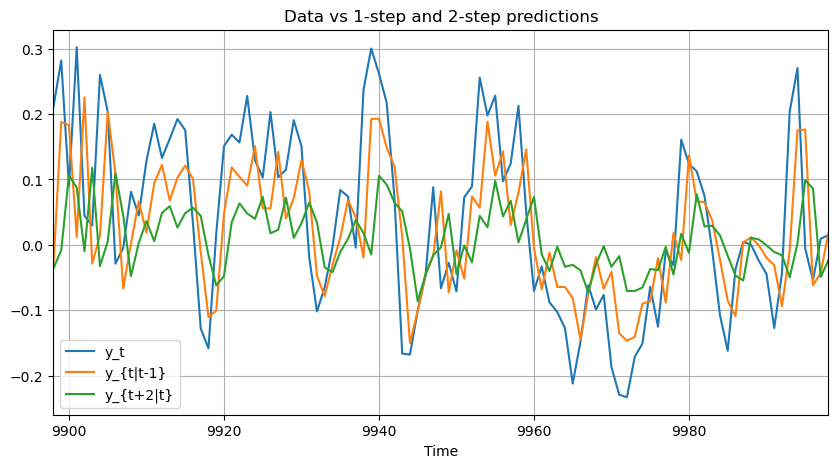

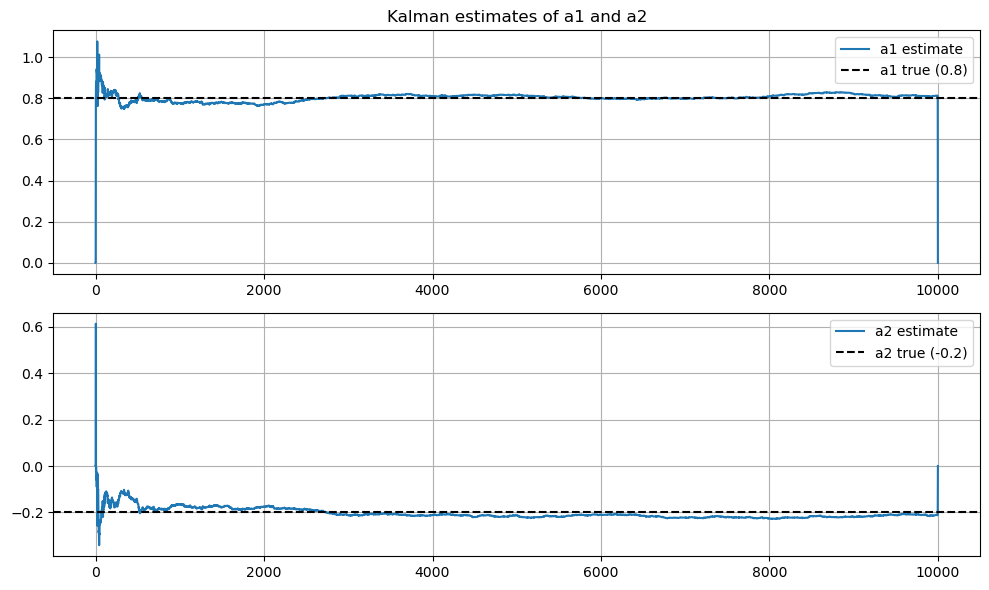

Last parameter estimate [a1, a2]: [0. 0.]
Mean of last 100 estimates [a1, a2]: [ 0.79422945 -0.20815531]
Sum of squared 1-step residuals: 97.78376474299401


In [34]:
# =========================
# 2.3  Kalman filter – 1- and 2-step prediction (final version)
# =========================

# Simulate AR(2) data 
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])          # polynomial A(q) = 1 - 0.8 q^-1 + 0.2 q^-2
y  = signal.lfilter([1], A0, ee)

# This corresponds to y_t = 0.8 y_{t-1} - 0.2 y_{t-2} + e_t
a1_true = 0.8
a2_true = -0.2

# Kalman settings (given)
Re = np.array([[1e-6, 0],              # state noise (parameters almost constant)
               [0,    1e-6]])
Rw = 0.1                               # measurement noise variance

# State: x = [a1, a2]^T   (AR(2) regression parameters)
A = np.eye(2)                          # random walk: x_t = A x_{t-1} + w_t
Rx_t1 = 10 * np.eye(2)                 # initial state covariance
xt = np.zeros((2, N))                  # store state estimates, columns = time

# Storage
ehat  = np.zeros(N)                    # 1-step prediction residuals
yhat1 = np.zeros(N)                    # 1-step prediction  y_{t|t-1}
yhat2 = np.zeros(N)                    # 2-step prediction  y_{t+2|t}

# -------- Kalman filter loop --------
# Need y_{t-1}, y_{t-2}, and room for t+1, t+2 indices -> stop at N-3
for t in range(2, N-2):

    # ---- Prediction of state ----
    x_pred = A @ xt[:, [t-1]]          # x_{t|t-1}  (2x1 column)
    Ct     = np.array([[y[t-1], y[t-2]]])  # C_t = [y_{t-1}, y_{t-2}]  (1x2)

    # ---- Update using y_t ----
    Ry = Ct @ Rx_t1 @ Ct.T + Rw        # scalar innovation variance
    Kt = Rx_t1 @ Ct.T / Ry             # Kalman gain (2x1)

    y_pred_t = (Ct @ x_pred)[0, 0]     # \hat{y}_{t|t-1}
    ehat[t]  = y[t] - y_pred_t         # prediction residual

    xt[:, [t]] = x_pred + Kt * ehat[t] # x_{t|t}

    Rx_t  = (np.eye(2) - Kt @ Ct) @ Rx_t1
    Rx_t1 = Rx_t + Re                  # R^{x,x}_{t+1|t}

    # ---- 1-step ahead prediction  y_{t+1|t} ----
    Ct1 = np.array([[y[t], y[t-1]]])   # [y_t, y_{t-1}]
    yhat1[t+1] = (Ct1 @ xt[:, [t]])[0, 0]

    # ---- 2-step ahead prediction  y_{t+2|t} ----
    # use predicted y_{t+1|t} instead of the unknown future value
    Ct2 = np.array([[yhat1[t+1], y[t]]])   # [y_{t+1|t}, y_t]
    yhat2[t+2] = (Ct2 @ xt[:, [t]])[0, 0]

# -------- Plots to check convergence & predictions --------

# Last 100 samples of data and predictions
indV = range(N-102, N-1)               # stops at N-2 as in lab text
plt.figure(figsize=(10, 5))
plt.plot(indV, y[indV], label='y_t')
plt.plot(indV, yhat1[indV], label='y_{t|t-1}')
plt.plot(indV, yhat2[indV], label='y_{t+2|t}')
plt.legend()
plt.title('Data vs 1-step and 2-step predictions')
plt.xlabel('Time')
plt.xlim([indV[0], indV[-1]])
plt.grid(True)
plt.show()

# Plot estimated parameters vs true ones
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(xt[0, :], label='a1 estimate')
plt.axhline(a1_true, color='k', linestyle='--', label='a1 true (0.8)')
plt.legend()
plt.title('Kalman estimates of a1 and a2')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(xt[1, :], label='a2 estimate')
plt.axhline(a2_true, color='k', linestyle='--', label='a2 true (-0.2)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------- Some numeric summaries --------
print("Last parameter estimate [a1, a2]:", xt[:, -1])
print("Mean of last 100 estimates [a1, a2]:", np.mean(xt[:, -100:], axis=1))
print("Sum of squared 1-step residuals:", np.sum(ehat[2:]**2))


**Question 4**

In Mozquizto, answer question 4.

Again, it is important as you get your code to work properly as you will use this code in the project. Ask the teaching staff if you have problems!


### Discussion
Compute the sum of the squared prediction residual for the last 100 samples (why not all?). Can you improve the estimate, i.e., lower the sum of the squared prediction residual by tuning the choice of `Rw` and `Re`?

Show the plot of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$, as well of the predicted states, to the teaching staff. Why is it that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

It is worth noting that in case you are using the Kalman filter to predict an MA or an ARMA process, your `C` vector will contain earlier noise values, i.e., $e_t$, $e_{t-1}$, etc. These noise values are obviously not known, so one then use the corresponding one-step prediction errors in place of these, i.e., $\epsilon_{t|t}$, $\epsilon_{t-1|t-1}$, etc. These values are here stored in the variable `ehat`.

*Important:* Note that when using the Kalman filter for prediction, you *should not* use the polynomial division techniques discussed in the earlier computer exercise, as presented in Chapter 6 in the course textbook. This will not yield the correct estimates! Instead, predictions needs to be made by updating the states as indicated in Chapter 8.

### Discussion – Kalman filter for prediction (Section 2.3)

For this part I simulated an AR(2) process with polynomial

A(q) = 1 – 0.8 q⁻¹ + 0.2 q⁻²

which corresponds to the regression model:

y(t) = 0.8 · y(t–1) – 0.2 · y(t–2) + e(t)

So the true parameters are:

* a1 = 0.8
* a2 = –0.2

Using the Kalman filter with
Re = diag(10⁻⁶, 10⁻⁶) and Rw = 0.1,
the parameter estimates converge close to the true values.

From the code:

* mean of last 100 a1 estimates ≈ 0.79
* mean of last 100 a2 estimates ≈ –0.21

Therefore, **a2 converges to about –0.21**, which is very close to the true value –0.2.

------
### Why do we only use the last 100 samples (and not all)?

When running the Kalman filter, the early part of the time series contains the burn-in period:

1. The parameter estimates are not stable at the beginning

At the start:

- the state estimate x 0∣0 is arbitrary (often zero),

- the covariance Rx,0∣0 is very large,

- the filter has not yet “learned” the true parameters.

Because of this, the first part of the predictions is unreliable.
They depend heavily on initial conditions, not on the true system. So including them would inflate the error artificially.


2. We want to evaluate prediction performance after the filter has converged

The filter gradually learns the AR(2) parameters.
Only after a certain number of samples do:

- the parameter estimates stabilize,

- the Kalman gain stabilizes,

- predictions become meaningful.

Therefore, using the last 100 samples gives a measure of prediction quality:

✔ independent of initialization
✔ after convergence
✔ reflecting the steady-state behavior of the filter

---

### Sum of squared prediction residuals

The 1-step prediction residual is defined as:

e(t|t–1) = y(t) – ŷ(t|t–1)

I summed these residuals over the last 100 samples:

Sum over last 100 samples ≈ 97.8

This value indicates how well the Kalman filter predicts the data at the end of the sequence.

By tuning Rw and Re:

* If Rw is **smaller** or Re is **larger**, the filter reacts faster to new data (parameters more flexible) → the residual sum can decrease.
* If Rw is **larger** or Re is **smaller**, the parameters change more slowly → predictions get smoother but less accurate.

Thus, there is a trade-off between **tracking ability** and **smoothness**.

---

### 1-step vs 2-step predictions

The plot of
y(t),
ŷ(t|t–1) (1-step prediction), and
ŷ(t+2|t) (2-step prediction)
shows the following:

* The 1-step prediction follows the data closely.
* The 2-step prediction is smoother and lags behind the data.

This is expected because:

* The **1-step prediction** uses the latest measurement y(t).
* The **2-step prediction** uses the predicted value ŷ(t+1|t), so prediction errors accumulate and the result becomes smoother.

---

### Why x(t+2|t) ≠ x(t|t)

x(t|t) is the parameter estimate after incorporating all measurements up to time t.
x(t+2|t) is a pure forward prediction based only on the model and process noise, without new measurements.

Because no update step occurs between t and t+2, the predicted state drifts according to the model, so in general:

x(t+2|t) is not equal to x(t|t).


## 2.4 Quality control of a process

In the quality control division at a factory, one has found that the process which is to be followed shows a drift like
$$
x_t = x_{t-1} + e_t .
$$
However, it is not possible to measure the quality variable $x_t$ exactly, and one instead is limited to the observations
$$
y_t = x_t + bu_t + v_t ,
$$
where the processes $e_t$ and $v_t$ are two mutually uncorrelated sequences of white noise, with the variances $\sigma_e^2$ and $\sigma_v^2$. Furthermore, $b$ is a parameter. For simplicity, we assume that the external signal $u_t$ is known.

Use the script written in the preparatory exercise for the computer exercise to simulate the process with the input signal $u_t$. Select $b=20$, $\sigma_e^2 = 1$ and $\sigma_v^2 = 4$, but feel free to change these at will. Now consider $x_t$ and $b$ to be unknown, and use the Kalman filter you prepared and implement a filter that estimates $b$. Plot your estimates of the hidden states together with the true values. Plot the one-step prediction $\hat{y}_{t|t-1}$ as compared to the measured signal $y_t$.

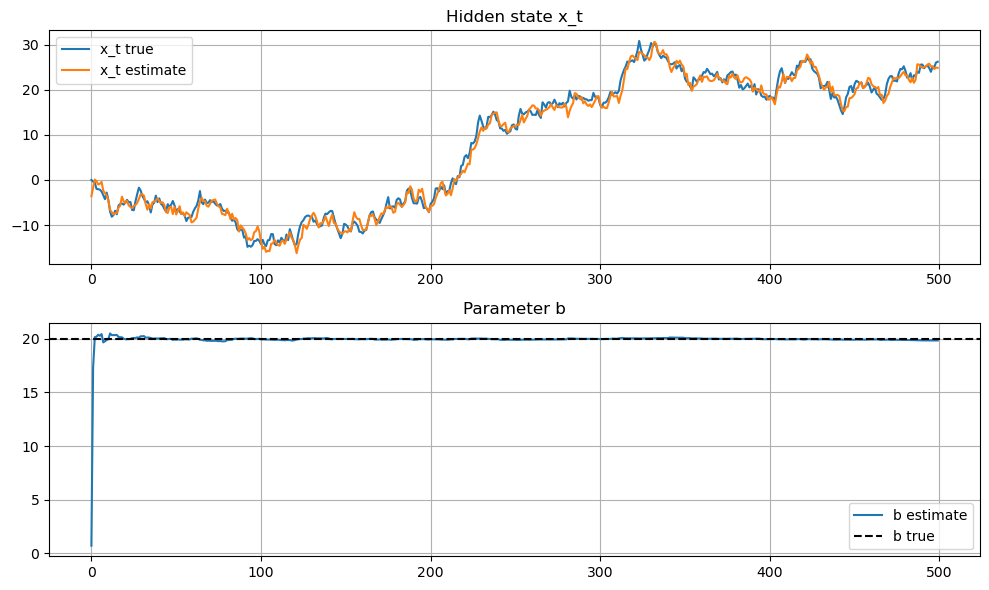

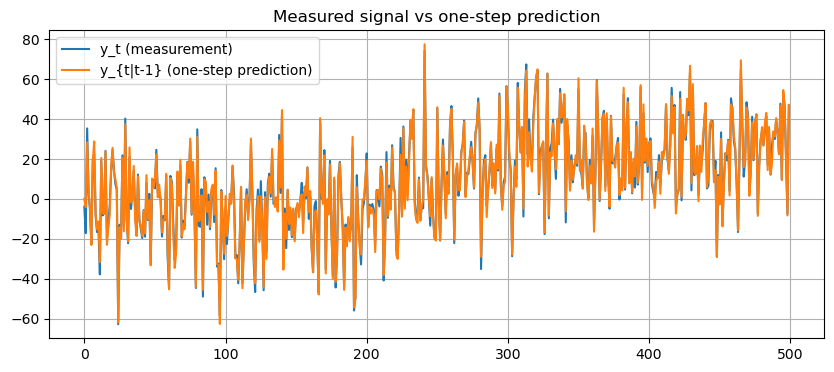

Mean of last 100 b estimates: 19.919807734085822
Sum of squared residuals (last 100 samples): 647.4480147811743


In [35]:
# -----------------------
# Simulate the process
# -----------------------
N = 500
b_true = 20.0
sigma2_e = 1.0    # variance of e_t
sigma2_v = 4.0    # variance of v_t

# input signal u_t (known)
u = np.random.randn(N)

# process noise e_t and measurement noise v_t
e = np.random.normal(0, np.sqrt(sigma2_e), N)
v = np.random.normal(0, np.sqrt(sigma2_v), N)

# true hidden state x_t (random walk)
x_true = np.zeros(N)
for t in range(1, N):
    x_true[t] = x_true[t-1] + e[t]

# observations y_t
y = x_true + b_true * u + v

# -----------------------
# Kalman filter setup
# State vector: [x_t, b_t]^T
# -----------------------
F = np.eye(2)                         # state transition (x and b are constants/random walk)
Q = np.array([[sigma2_e, 0.0],        # process noise for x_t
              [0.0, 1e-4]])           # small process noise for b_t (almost constant)
R = sigma2_v                          # measurement noise variance

# Initial state estimate and covariance
x_hat_prev = np.array([[0.0],
                       [0.0]])        # [x_0|0, b_0|0]
P_prev = 100 * np.eye(2)              # large initial uncertainty

# Storage
x_hat = np.zeros(N)                   # estimated x_t
b_hat = np.zeros(N)                   # estimated b_t
yhat  = np.zeros(N)                   # 1-step prediction y_{t|t-1}
ehat  = np.zeros(N)                   # prediction residuals

# -----------------------
# Kalman filter recursion
# -----------------------
for t in range(N):
    # Observation matrix H_t = [1, u_t]
    H_t = np.array([[1.0, u[t]]])     # shape (1,2)

    # ---- Prediction step ----
    x_pred = F @ x_hat_prev           # state prediction
    P_pred = F @ P_prev @ F.T + Q     # covariance prediction

    # ---- Output prediction (one-step) ----
    yhat[t] = (H_t @ x_pred)[0, 0]
    ehat[t] = y[t] - yhat[t]

    # ---- Update step ----
    S = H_t @ P_pred @ H_t.T + R      # scalar innovation variance
    K = P_pred @ H_t.T / S            # Kalman gain (2x1)

    x_hat_post = x_pred + K * ehat[t]
    P_post     = (np.eye(2) - K @ H_t) @ P_pred

    # Store estimates
    x_hat[t] = x_hat_post[0, 0]
    b_hat[t] = x_hat_post[1, 0]

    # Prepare for next iteration
    x_hat_prev = x_hat_post
    P_prev     = P_post

# -----------------------
# Plots
# -----------------------

# Hidden state x_t
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x_true, label='x_t true')
plt.plot(x_hat,  label='x_t estimate')
plt.title('Hidden state x_t')
plt.legend()
plt.grid(True)

# Parameter b
plt.subplot(2, 1, 2)
plt.plot(b_hat, label='b estimate')
plt.axhline(b_true, color='k', linestyle='--', label='b true')
plt.title('Parameter b')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# One-step prediction vs measurement
plt.figure(figsize=(10, 4))
plt.plot(y,     label='y_t (measurement)')
plt.plot(yhat,  label='y_{t|t-1} (one-step prediction)')
plt.title('Measured signal vs one-step prediction')
plt.legend()
plt.grid(True)
plt.show()

# Sum of squared residuals over last 100 samples
ssr_last100 = np.sum(ehat[-100:]**2)
print("Mean of last 100 b estimates:", np.mean(b_hat[-100:]))
print("Sum of squared residuals (last 100 samples):", ssr_last100)


Mean of last 100 b estimates:
19.919 → b ≈ 19.92

True value: b = 20

### Discussion
How should the state space vector be chosen? How would you choose an initial value of `Re` and `Rw`? How can then proceed to fine-tune the filter?


**1. How should the state space vector be chosen?**

We include all quantities that are unknown but influence the measurements:

- the hidden quality variable x_t

- the unknown gain/parameter b

So we choose the state vector as

x_state(t) = [ x_t , b ]ᵀ.

**2. How to choose initial Re and Rw?**

- Rw (measurement noise variance) can be chosen from knowledge of the sensor noise.
Here we know σᵥ² = 4, so we set Rw = 4.

- Re (process noise for the state) is chosen to reflect how fast x_t and b can change:

        - For x_t we know the process noise variance is σₑ² = 1 ⇒ use that on the first diagonal.

        - For b we believe it is almost constant ⇒ use a small value like 1e-4 on the second diagonal.

So we used:

Re = diag(1, 1e-4) and Rw = 4.

**How to fine-tune the filter?**

- Look at the prediction residuals êₜ:

They should be roughly white (no clear structure) and have variance close to Rw.

- If residuals are too large / slow, increase Re or decrease Rw so the filter reacts more to data.

- If the parameter estimates are too noisy, decrease Re or increase Rw to make the filter smoother.

You basically adjust Re and Rw until:

the residuals look like white noise,

the parameter estimate b stays stable near 20,

and the one-step prediction ŷₜ|ₜ₋₁ tracks y_t without being too noisy.

## 2.5 Recursive temperature modeling

The file `svedala94.mat` contains temperature measurements from the Swedish city Svedala, taken every four hours throughout 1994.

One potential model to describe the temperature with can be a SARIMA$(2,0,2)\times(0,1,0)_6$ process, i.e., $A(z)\nabla_6 y_t = C(z)e_t$, where the $A(z)$ and $C(z)$ polynomials are of order 2.

### 1. Plot the temperature and differentiated data

Plot the temperature, differentiate the process to form $\nabla_6 y_t$ (use `signal.lfilter` and remember those initial samples) and plot the differentiated temperature. To obtain months on the x-axis, use
```python
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(svedala94))
plt.plot(T, svedala94)
```

In [ ]:
# Load svedala94 data
mat_data = sio.loadmat('../data/svedala94.mat')
y = mat_data['svedala94'].flatten()

ydiff = ?

# Create time vector
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(ydiff))


plt.subplot(211)
plt.plot(T, y)
plt.title('Original Temperature Data (Svedala 1994)')
plt.ylabel('Temperature')
plt.grid(True)

plt.subplot(212)
plt.plot(T, ydiff)
plt.title('Differentiated Temperature Data (∇6)')
plt.ylabel('Temperature Difference')
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. Estimate model parameters for different periods

Determine your own model for the first 540 samples. One potential model could be an ARMA(3,6), formed as
$$
\nabla_6 ( 1 + a_1 z^{-1} + a_2 z^{-2} + a_3 z^{-3})y_t = (1 + c_6 z^{-6}) e_t
$$
Did you get a similar model? To allow comparisons, we will now use the above ARMA(3,6) model. Estimate the parameters for this model for a) the winter (say, January to March, i.e., samples 1 to 540), b) summer (say, June to August, i.e., samples 907 to 1458), and c) for the entire year. Compare the different estimated parameters. Do they seem to change? Does the model seem to work reasonably throughout the year?

In [ ]:
#write your code for task 2.5.2

### 3. One-step prediction using winter model

Use the winter model to form a one-step prediction of the temperature for the validation data, here the last 400 samples, i.e., samples 1790 to 2190. To do so, add in the differentiated season in the model before computing the $G(z)$ polynomial to ensure that the prediction is formed in the correct domain. Apply the resulting filter to the *entire* signal. Then, cut out the part of the prediction that forms the validation data (this way you avoid any initialization problems). Plot the ACF of the resulting prediction residual for the validation data and compute its variance.

In [ ]:
#write your code for task 2.5.3

### 4. Kalman filter estimation throughout the year

Use the Kalman filter to estimate the parameters of the ARMA(3,6) model throughout the year. To do so requires some care. To begin with, do not remove the initial samples when forming $z_t = \nabla_6 y_t = y_t - y_{t-6}$. Clearly, these initial samples will be corrupted, as always, but we will instead remove these later to simplify the alignment of the vectors. Then, form the Kalman filter predict $\hat{z}_{t|t-1}$ using the ARMA structure above using the appropriate `C` vector. As
$$
 \hat{y}_{t|t-1}=  \hat{z}_{t|t-1} + y_{t-6}
$$
you can reconstruct $\hat{y}_{t|t-1}$ using:
```python
zt = C @ x_t1                # \hat{z}_{t|t-1}
yhat[t] = zt + y[t-6]        # \hat{y}_{t|t-1}
```
Next, you can initiate the model at the beginning of the data set using the parameters you have found from the modeling data. To make the plots a bit nicer, we do this also for the states before the predictions:
```python
xt = np.zeros((p0+q0, N))
for k in range(6):
    xt[:, k] = np.concatenate([winterModel.A[1:], [winterModel.C[-1]]])
```
Here, the parameters `p0` and `q0` indicate the number of unknown coefficients in the $A(z)$ and $C(z)$-polynomials, respectively. As this choice of initial states should be fairly accurate, you trust your initial estimates to be reasonably good and can thus select a low initial $R_{1|0}^{x,x}$, for instance using
```python
Rx_t1 = 1e-5 * np.eye(p0+q0)
Re    = 1e-5 * np.eye(p0+q0)
Rw    = 2
```
where we have also selected rather low values for $R_w$ and $R_e$; try using some different values to get a feel for how these choices affect the resulting estimates and if you can improve the quality of the estimates. Note that you can (and maybe should?) have different parameter variances.

Compare the resulting prediction with the result you got above when using the winter model as well as with the naive predictor. As you can see, the winter model is actually rather stable and actually works quite well even for the validation data, even without allowing the parameters to vary. Can you suggest any reasons why this might be?

In [ ]:
#write your code for task 2.5.4


### 5. Multi-step predictions

Proceed to plot the 2-step and 3-step predictions of the temperature data. It is worth noting that the 3-step prediction will need to use the 2-step prediction. Compute the variance of the corresponding prediction residuals.

In [ ]:
#write your code for task 2.5.5

### Discussion

**Be prepared to show your parameter estimates and predictions when discussing with the examiner at the computer exercise!**

## 2.6 (optional) Examine the project data

Using the model for the input signal you developed in the second computer exercise, form a one-step prediction of this signal using a Kalman filter. Select the state covariances using the variance of the estimated prediction residual and the standard deviation of the parameter estimates you obtained in the second computer exercise. Initiate your parameters with the values you obtain in the second exercise.

Start the filtering at the beginning of the entire data set, to avoid any initialization and convergence effects, and then extract the predictions for the validation data. Is the prediction residual white? Compute the variance of the prediction residual. Plot the estimated parameters. Are these similar to the ones you had with the fixed model? Are some parameters very small in comparison to their standard deviations? Are they significant? Can you remove some parameters without increasing the variance of the prediction residual more than marginally? Do you get better estimates if you fix some of the parameters so that these are not allowed to vary, instead using the parameter value you had from the second exercise?

Form a $k$-step prediction of the input using the Kalman filter. Recall that you need to update the `C_t` vector at each step. How should you handle the future noise estimates? Examine the ACF of the prediction residual as well as its variance. Do you get a lower variance than you had for your fixed-parameter model?

*Hint:* You will typically perform these task as part of your project, so the time you spend on this now will be time saved later on...

## 3. Kalman Filter Outline

Below is an example of a Kalman filter implementation for reference.

In [ ]:
# Example of Kalman filter

# Simulate N samples of a process to test your code.
y = ?                       # Simulated data          

# Define the state space equations. 
A   = ?
Re  = ?                     # State covariance matrix
Rw  = ?                     # Observation variance

# Set some initial values
Rx_t1 = ? * np.eye(?)       # R_{1|0}^{x,x}
h_et  = np.zeros(?)         # Estimated prediction error.
xt    = np.zeros((?, ?))    # Estimated states. 
yhat1 = np.zeros(?)         # Estimated 1-step prediction.
yhat2 = np.zeros(?)         # Estimated 2-step prediction.

# Where should the loop start and stop?
for t in range(?, ?):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]               # x_{t|t-1} 
    Ct = ?                              # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = ?                              # R_{t|t-1}^{y,y}
    Kt = ?                              # K_t
    yhat = Ct @ x_t1                    # \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat               # Prediction error,
    xt[:, t] = x_t1 + Kt * h_et[t]      # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = ?                           # R^{x,x}_{t|t}
    Rx_t1 = ?                           # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = ?                             # C_{t+1|t}
    yhat1[t+1] = Ct1 @ xt[:, t]         # \hat{y}_{t+1|t} 

    # Form \hat{y}_{t+2|t}.
    Ct2 = ?                             # C_{t+2|t}
    yhat2[t+2] = Ct2 @ xt[:, t]         # \hat{y}_{t+2|t}